In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# Notebook: OverlappingT293withHUVEC.ipynb
# Purpose:
#   Part 1) Extract mtRNA-associated DNA-end sites from iMARGI .pairs.gz,
#            merge nearby sites (±250 bp), and write per-sample BED files.
#   Part 2) Compute and visualize overlap between NCOR/GPS2 TF peaks and
#            these mtRNA-binding regions.
#   Part 3) Perform Fisher’s exact tests on overlap counts:
#            • Intra-group (same condition across timepoints)
#            • Inter-group (different conditions at same timepoint)
# ─────────────────────────────────────────────────────────────────────────────


# This script extracts DNA-end sites associated with mtRNA (chrM) from iMARGI .pairs.gz files,
# merges nearby sites (±250 bp), and saves them as BED files for each sample.

# Cell 1: Extract mtRNA-binding DNA sites and save as BED
import gzip
import pybedtools
import os

# Paths to iMARGI .pairs.gz files
pairs_files = {
    "Control": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900120.pairs.gz",
    "HG+TNFα Day3": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900121.pairs.gz",
    "HG+TNFα Day7": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900122.pairs.gz"
}

# Output directory for merged mtRNA sites
outdir = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap"
os.makedirs(outdir, exist_ok=True)

for name, pairs_file in pairs_files.items():
    dna_sites = []
    # Read compressed .pairs.gz line by line
    with gzip.open(pairs_file, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue  # Skip header/comment lines
            cols = line.strip().split("\t")
            rna_chr = cols[1]       # RNA-end chromosome
            dna_chr = cols[3]       # DNA-end chromosome
            dna_pos = int(cols[4])  # DNA-end position

            # Keep only pairs where RNA-end is mitochondrial
            if rna_chr in ["chrM", "chrMT", "MT"]:
                # Record a 1-bp interval at the DNA-end site
                dna_sites.append([dna_chr, dna_pos, dna_pos + 1])

    if not dna_sites:
        print(f"{name}: No mtRNA-binding read pairs found!")
        continue

    # Merge intervals within ±250 bp (i.e., max gap = 500 bp)
    dna_bed = (
    pybedtools.BedTool(dna_sites) 
    .sort()                        
    .slop(b=250, genome="hg38")    
    .merge()                     
)
    
    # Save merged intervals as BED
    outfile = os.path.join(outdir, f"mtRNA_DNA_sites_{name}.bed")
    dna_bed.saveas(outfile)
    print(f"{name}: Generated {outfile}, regions = {len(dna_bed)}")



Control: Generated /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/mtRNA_DNA_sites_Control.bed, regions = 294752
HG+TNFα Day3: Generated /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/mtRNA_DNA_sites_HG+TNFα Day3.bed, regions = 380812
HG+TNFα Day7: Generated /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/mtRNA_DNA_sites_HG+TNFα Day7.bed, regions = 368771


In [5]:
#Overlap with HUVEC
outdir = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap"


=== siCTL: total peaks = 36406 ===
siCTL - Control: overlap = 6163, 16.93%  -> saved /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/overlap_siCTL_Control.bed
siCTL - HG+TNFα Day3: overlap = 7628, 20.95%  -> saved /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/overlap_siCTL_HG+TNFα_Day3.bed
siCTL - HG+TNFα Day7: overlap = 8761, 24.06%  -> saved /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/overlap_siCTL_HG+TNFα_Day7.bed

=== siGPS2: total peaks = 9302 ===
siGPS2 - Control: overlap = 1523, 16.37%  -> saved /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/overlap_siGPS2_Control.bed
siGPS2 - HG+TNFα Day3: overlap = 1844, 19.82%  -> saved /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/overlap_siGPS2_HG+TNFα_Day3.bed
siGPS2 - HG+TNFα Day7: overlap = 2140, 23.01%  -> saved /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/overlap_siGPS2_HG+TNFα_Day7.bed

=== GPS2: total peaks = 33437 ===
G

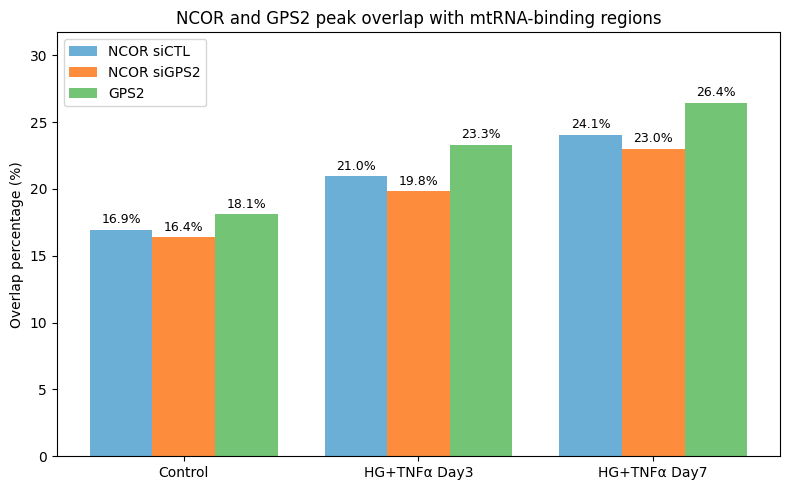

In [6]:
# Cell 2: Overlap mtRNA sites with NCOR/GPS2 peaks and plot percentages
import pybedtools
import pandas as pd
import matplotlib.pyplot as plt

# === Input BEDs ===
mtRNA_files = {
    "Control": f"{outdir}/mtRNA_DNA_sites_Control.bed",
    "HG+TNFα Day3": f"{outdir}/mtRNA_DNA_sites_HG+TNFα Day3.bed",
    "HG+TNFα Day7": f"{outdir}/mtRNA_DNA_sites_HG+TNFα Day7.bed"
}

# TF peak BEDs for three conditions
peak_files = {
    "siCTL": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T293/Peak_file/NCOR_siCTL_hg38.bed",
    "siGPS2": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T293/Peak_file/NCOR_siGPS2_hg38.bed",
    "GPS2": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T293/Peak_file/GPS2_minusTNFA_hg38.bed"
}

results_all = []
# Loop through each TF condition
for condition, peaks_path in peak_files.items():
    peaks_bed    = pybedtools.BedTool(peaks_path)
    total_peaks  = len(peaks_bed)  # Number of peaks in this condition
    print(f"\n=== {condition}: total peaks = {total_peaks} ===")

    # Compare against each mtRNA site set
    for day, mtRNA_path in mtRNA_files.items():
        mtRNA_bed  = pybedtools.BedTool(mtRNA_path)

        # Count peaks overlapping any mtRNA interval
        overlap_bed = peaks_bed.intersect(mtRNA_bed, u=True)

        # save overlap regions
        save_dir = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap"
        os.makedirs(save_dir, exist_ok=True)  
        overlap_filename = os.path.join(
            save_dir,
        f"overlap_{condition.replace(' ', '_')}_{day.replace(' ', '_')}.bed"
        )
        overlap_bed.saveas(overlap_filename)
        
        overlap_count = overlap_bed.count()
        percentage = (overlap_count / total_peaks * 100) if total_peaks else 0
        results_all.append([condition, day, total_peaks, overlap_count, percentage])
        print(f"{condition} - {day}: overlap = {overlap_count}, {percentage:.2f}%  -> saved {overlap_filename}")

# Build DataFrame of overlap stats
df = pd.DataFrame(
    results_all,
    columns=["Condition", "Sample", "Total peaks", "Overlap count", "Percentage (%)"]
)
print("\n=== Overlap statistics ===")
print(df.to_string(index=False))

# Save stats to CSV
df.to_csv("NCOR_GPS2_mtRNA_overlap_stats.csv", index=False)

# Plot grouped bar chart of overlap percentages
plt.figure(figsize=(8, 5))
color_palette = {
    "NCOR siCTL": "#6baed6",
    "NCOR siGPS2": "#fd8d3c",
    "GPS2": "#74c476"
}
cond_mapping = {
    "NCOR siCTL": "siCTL",
    "NCOR siGPS2": "siGPS2",
    "GPS2": "GPS2"
}

n_days = len(mtRNA_files)
conds = list(color_palette.keys())
bar_width = 0.8 / len(conds)

for i, day in enumerate(mtRNA_files):
    for j, cond in enumerate(conds):
        pct = df.loc[
            (df["Condition"] == cond_mapping[cond]) & (df["Sample"] == day),
            "Percentage (%)"
        ].values[0]
        x = i + j * bar_width - 0.4 + bar_width / 2
        plt.bar(x, pct, width=bar_width, color=color_palette[cond],
                label=cond if i == 0 else "")
        plt.text(x, pct + 0.5, f"{pct:.1f}%", ha="center", fontsize=9)

plt.xticks(range(n_days), mtRNA_files.keys())
plt.ylabel("Overlap percentage (%)")
plt.title("NCOR and GPS2 peak overlap with mtRNA-binding regions")
plt.ylim(0, df["Percentage (%)"].max() * 1.2)
plt.legend()
plt.tight_layout()
plt.show()



Regardless of whether GPS2 is knocked down, the overlap percentage between mtRNA-binding regions and NCOR peaks increases significantly as the treatment duration is extended.
  
The overlap between mtRNA-binding regions and NCOR peaks increases with longer high glucose + TNFα treatment, regardless of GPS2 knockdown

GPS2 knockdown greatly reduces this overlap (OR ≈ 5), indicating GPS2 is essential for maintaining the interaction between these regions

/projectnb/perissilab/Xinyu/.conda/envs/chip_seq/lib/python3.12/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
join: Strand data from other will be added as

=== Gene-level overlap percentage matrix (%) ===
             NCOR siCTL NCOR siGPS2   GPS2
Control           36.07       16.13  27.97
HG+TNFα_Day3      33.72       14.77  26.38
HG+TNFα_Day7      34.37       15.01  26.98

=== Overlap statistics ===
  Condition       Sample  Total genes  Overlap count  Percentage (%)
 NCOR siCTL      Control        16253           9767       36.068540
NCOR siGPS2      Control         6964           4368       16.130581
       GPS2      Control        13261           7575       27.973707
 NCOR siCTL HG+TNFα_Day3        16253          10776       33.717146
NCOR siGPS2 HG+TNFα_Day3         6964           4720       14.768461
       GPS2 HG+TNFα_Day3        13261           8432       26.382979
 NCOR siCTL HG+TNFα_Day7        16253          11170       34.370288
NCOR siGPS2 HG+TNFα_Day7         6964           4879       15.012770
       GPS2 HG+TNFα_Day7        13261           8767       26.976215


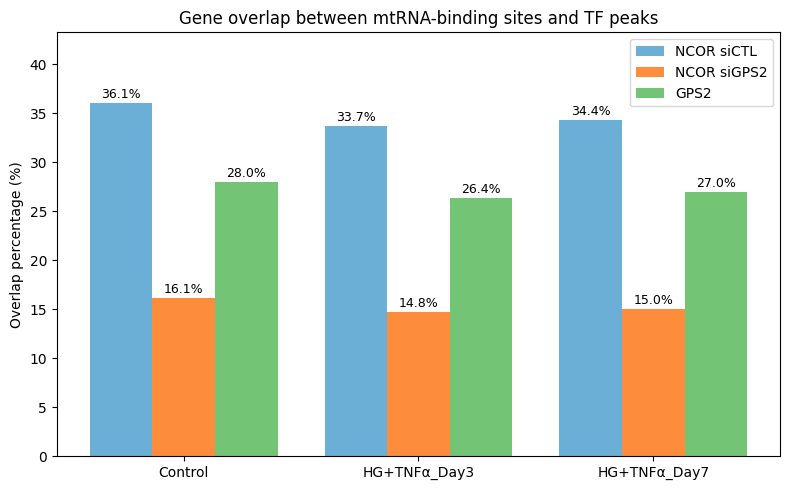

Saved plot to: /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/gene_overlap_percentages.png


In [7]:
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
import os
# Purpose:
#     This script compares the gene-level overlap between mitochondrial RNA (mtRNA)-binding DNA sites 
#     and transcription factor (TF) binding peaks (NCOR, GPS2) across multiple experimental conditions.

# Workflow:
#     1. Read GTF annotation and construct promoter regions (TSS ± 2 kb) for all genes.
#     2. Map each BED file (mtRNA-binding regions or TF peaks) to the list of genes whose promoters overlap these regions.
#     3. Save gene lists for:
#         - mtRNA-binding sites per condition
#         - TF peaks per condition
#     4. Compute the overlap between mtRNA-binding gene sets and TF peak gene sets:
#         - Calculate the number and percentage of overlapping genes
#         - Save overlapping gene lists for each comparison
#     5. Output:
#         - "genes_mtRNA_<day>.txt": genes bound by mtRNA-binding sites for each condition
#         - "genes_peak_<condition>.txt": genes bound by TF peaks for each condition
#         - "genes_overlap_<day>_<condition>.txt": genes bound by both mtRNA-binding sites and TF peaks
#         - "gene_overlap_percentage_matrix.csv": table of overlap percentages (rows = mtRNA condition, cols = TF condition)
#         - "gene_overlap_detailed_stats.csv": table with total genes, overlap counts, and percentages

# Inputs:
#     - GTF annotation file (e.g., Homo_sapiens.GRCh38.84.gtf.gz)
#     - BED files of mtRNA-binding DNA sites (per condition)
#     - BED files of TF ChIP-seq peaks (per condition)

# Outputs:
#     - Gene lists for each condition (mtRNA and TF peaks)
#     - Overlap gene lists for each comparison
#     - Overlap percentage matrix CSV
#     - Detailed statistics CSV

# ============================
# Step 0: Path setup
# ============================
gtf_path = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/ref/Homo_sapiens.GRCh38.84.gtf.gz"

# Read GTF and unify chromosome naming to match BED format (chr1, chr2, ...)
gtf = pr.read_gtf(gtf_path)
gtf.Chromosome = gtf.Chromosome.apply(lambda x: "chr" + x if not x.startswith("chr") else x)

# Input mtRNA-binding DNA sites BED files (per condition)
mtRNA_files = {
    "Control": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/mtRNA_DNA_sites_Control.bed",
    "HG+TNFα_Day3": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/mtRNA_DNA_sites_HG+TNFα Day3.bed",
    "HG+TNFα_Day7": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/Overlap/mtRNA_DNA_sites_HG+TNFα Day7.bed"
}

# Input TF peak BED files
peak_files = {
    "NCOR siCTL": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T293/Peak_file/NCOR_siCTL_hg38.bed",
    "NCOR siGPS2": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T293/Peak_file/NCOR_siGPS2_hg38.bed",
    "GPS2": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T293/Peak_file/GPS2_minusTNFA_hg38.bed"
}

# Output directory for gene lists and results
outdir = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis"
os.makedirs(outdir, exist_ok=True)

# ============================
# Step 1: Generate promoter regions from GTF (TSS ± 2kb)
# ============================
def gtf_to_promoters(gtf, flank=2000):
    """
    Convert GTF annotation to promoter regions (TSS ± flank bp).
    Returns a PyRanges object with promoter coordinates and gene info.
    """
    genes = gtf[gtf.Feature == "gene"]
    promoters = []
    for row in genes.df.itertuples(index=False):
        if row.Strand == "+":
            start = max(0, row.Start - flank)
            end = row.Start + flank
        else:
            start = max(0, row.End - flank)
            end = row.End + flank
        promoters.append([row.Chromosome, start, end, row.gene_id, row.gene_name, row.Strand])
    prom_df = pd.DataFrame(promoters, columns=["Chromosome", "Start", "End", "gene_id", "gene_name", "Strand"])
    return pr.PyRanges(prom_df)

promoters = gtf_to_promoters(gtf, flank=2000)

# Step 2: Map BED to gene list
def bed_to_gene_list(bed_path, promoters):
    """
    Given a BED file and promoter regions, return the set of overlapping gene names.
    """
    bed = pr.read_bed(bed_path)
    overlap = bed.join(promoters)
    return set(overlap.df["gene_name"])


# Step 3: Generate and save gene lists for mtRNA-binding sites and TF peaks
mtRNA_genes = {}
for day, path in mtRNA_files.items():
    genes = bed_to_gene_list(path, promoters)
    mtRNA_genes[day] = genes
    with open(os.path.join(outdir, f"genes_mtRNA_{day}.txt"), "w") as f:
        for g in sorted(genes):
            f.write(g + "\n")

peak_genes = {}
for cond, path in peak_files.items():
    genes = bed_to_gene_list(path, promoters)
    peak_genes[cond] = genes
    with open(os.path.join(outdir, f"genes_peak_{cond}.txt"), "w") as f:
        for g in sorted(genes):
            f.write(g + "\n")

# Step 4: Compute overlap statistics and save results
overlap_matrix = pd.DataFrame(index=mtRNA_genes.keys(), columns=peak_genes.keys())
stats_all = []

for day, m_genes in mtRNA_genes.items():
    for cond, p_genes in peak_genes.items():
        overlap = m_genes & p_genes
        pct = len(overlap) / len(m_genes) * 100 if m_genes else 0
        overlap_matrix.loc[day, cond] = round(pct, 2)
        
        # Save overlapping genes for this comparison
        with open(os.path.join(outdir, f"genes_overlap_{day}_{cond}.txt"), "w") as f:
            for g in sorted(overlap):
                f.write(g + "\n")
        
        # Add detailed stats for table output
        stats_all.append([cond, day, len(p_genes), len(overlap), pct])

# Save overlap percentage matrix
overlap_matrix.to_csv(os.path.join(outdir, "gene_overlap_percentage_matrix.csv"))

print("=== Gene-level overlap percentage matrix (%) ===")
print(overlap_matrix)

# Step 5: Print detailed overlap statistics table
df_stats = pd.DataFrame(stats_all, columns=["Condition", "Sample", "Total genes", "Overlap count", "Percentage (%)"])
print("\n=== Overlap statistics ===")
print(df_stats.to_string(index=False))

# Save the detailed stats table
df_stats.to_csv(os.path.join(outdir, "gene_overlap_detailed_stats.csv"), index=False)

# Step 6: Plot grouped bar chart of overlap percentages

import numpy as np
# Desired order of samples (y-axis groups) and TF conditions (bar groups)
sample_order = ["Control", "HG+TNFα_Day3", "HG+TNFα_Day7"]
cond_order   = ["NCOR siCTL", "NCOR siGPS2", "GPS2"]

# Pivot the statistics table so rows = mtRNA conditions, columns = TF conditions
plot_df = df_stats.pivot(index="Sample", columns="Condition", values="Percentage (%)")

# Reorder rows/columns according to desired plotting order
plot_df = plot_df.reindex(index=sample_order, columns=cond_order).fillna(0)

# Color palette for each TF condition
color_palette = {
    "NCOR siCTL": "#6baed6",
    "NCOR siGPS2": "#fd8d3c",
    "GPS2": "#74c476"
}

plt.figure(figsize=(8, 5))

# Number of sample groups and number of bars per group
n_groups = len(plot_df.index)
n_bars   = len(plot_df.columns)
bar_width = 0.8 / n_bars  # total bar cluster width = 0.8
x = np.arange(n_groups)   # x positions for sample groups

# Plot each condition's bars
for j, cond in enumerate(plot_df.columns):
    # Offset each bar so they are grouped side-by-side
    offset = (j - (n_bars - 1) / 2) * bar_width
    heights = plot_df[cond].values.astype(float)
    plt.bar(x + offset, heights, width=bar_width, label=cond, color=color_palette.get(cond, None))
    
    # Add percentage labels above each bar
    for i, h in enumerate(heights):
        plt.text(x[i] + offset, h + 0.5, f"{h:.1f}%", ha="center", fontsize=9)

# Formatting
plt.xticks(x, plot_df.index, rotation=0)
plt.ylabel("Overlap percentage (%)")
plt.title("Gene overlap between mtRNA-binding sites and TF peaks")
ymax = float(np.nanmax(plot_df.values)) if plot_df.values.size else 0
plt.ylim(0, ymax * 1.2 + 1e-6)
plt.legend()
plt.tight_layout()

# Save the plot
fig_path = os.path.join(outdir, "gene_overlap_percentages.png")
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"Saved plot to: {fig_path}")
